In [39]:
import os
import re
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
import freud

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize
%config InlineBackend.figure_format = 'retina'

def load_file(filename_folder):
    """Loads the data from a single file."""
    filename, folder = filename_folder
    return np.load(os.path.join(folder, filename))

def load_data_parallel(folder, prefix):
    """Loads all files that start with the specified prefix in parallel."""
    # Get all files with the specified prefix
    filenames = [filename for filename in sorted(os.listdir(folder), key=safe_extract_number) if filename.startswith(prefix)]
    print(print('#frames =', len(filenames)))
    # Use multiprocessing to load the files in parallel
    with Pool() as pool:
        results = pool.map(load_file, [(filename, folder) for filename in filenames])

    if 'traj' in prefix:
        results = np.concatenate(results, axis=0)
    if 'time' in prefix:
        results = np.concatenate(results, axis=0)
    results = np.array(results)
    return results


def safe_extract_number(filename: str) -> int:
    """
    Extract the last integer found in the filename for natural sorting.
    Returns 0 if no number is found.
    """
    numbers = re.findall(r"\d+", filename)
    return int(numbers[-1]) if numbers else 0


def reshape_to_polymers(traj: np.ndarray, M: int) -> np.ndarray:
    """
    Reshape trajectory from (T, M*Nprobe, 3) to (M, T, Nprobe, 3).

    Parameters
    ----------
    traj : np.ndarray
        Array of shape (T, M*Nprobe, 3).
    M : int
        Number of polymers.

    Returns
    -------
    traj_poly : np.ndarray
        Array of shape (M, T, Nprobe, 3).
    """
    T, total_beads, dim = traj.shape
    if dim != 3:
        raise ValueError(f"Expected last dimension = 3, got {dim}")

    if total_beads % M != 0:
        raise ValueError(f"total_beads = {total_beads} is not divisible by M = {M}")

    Nprobe = total_beads // M
    traj_poly = np.empty((M, T, Nprobe, 3), dtype=traj.dtype)

    for m in range(M):
        start = m * Nprobe
        end = (m + 1) * Nprobe
        traj_poly[m] = traj[:, start:end, :]

    print(f"Reshaped trajectory to (M={M}, T={T}, Nprobe={Nprobe}, 3).")
    return traj_poly

def extract_rij(traj_poly: np.ndarray, k: int, shift: int = 1) -> np.ndarray:
    """
    Extract 3D joining vectors r_ij(t) for monomer pairs separated by k monomers.

    Parameters
    ----------
    traj_poly : np.ndarray
        Trajectory with shape (M, T, Nprobe, 3).
    k : int
        Genomic separation (in monomers) between i and j (j = i + k).
    shift : int, optional
        Step with which we sample monomer pairs i, i+k along the chain.
        E.g. shift=1 uses every possible i, shift=5 uses every 5th monomer.

    Returns
    -------
    rij : np.ndarray
        Array of shape (T, Npairs, 3), where Npairs is the total number of
        (polymer, monomer) pairs extracted.
    """
    M, T, Nprobe, _ = traj_poly.shape
    if k >= Nprobe:
        raise ValueError(f"k={k} must be smaller than Nprobe={Nprobe}")

    # We will create all pairs (m, i, i+k) with step `shift` in i
    pairs = []
    for m in range(M):
        for i in range(0, Nprobe - k, shift):
            R_i = traj_poly[m, :, i, :]      # shape (T, 3)
            R_j = traj_poly[m, :, i + k, :]  # shape (T, 3)
            pairs.append(R_i - R_j)          # shape (T, 3)

    rij = np.stack(pairs, axis=1)  # shape (T, Npairs, 3)
    print(f"Extracted rij with shape {rij.shape} (T, Npairs, 3).")
    return rij

def compute_fpts(signal: np.ndarray,
                 target_size: float,
                 Nsamples: int = 10_000,
                 t_min: int = 1) -> np.ndarray:
    """
    Compute first-passage times (FPTs) to reach distance < target_size.

    Parameters
    ----------
    signal : np.ndarray
        1D array of shape (T,) giving distance as a function of time.
    target_size : float
        Threshold distance defining "contact": we look for signal < target_size.
    Nsamples : int, optional
        Number of random starting times t from which we sample FPTs.
    t_min : int, optional
        Ignore early time points (0..t_min) to skip transients.

    Returns
    -------
    fpts : np.ndarray
        Array of FPTs (in time steps). May be empty if the target is never reached
        after the sampled starting points.
    """
    T = len(signal)
    if t_min >= T:
        raise ValueError("t_min must be smaller than the length of the signal.")

    # Times when the target is reached
    target_reached = signal < target_size
    first_passage_times = np.where(target_reached)[0]  # indices t where signal[t] < target_size

    if first_passage_times.size == 0:
        # Never hits the target
        return np.array([])

    # Random starting times between t_min and T-1
    ts = np.random.randint(t_min, T, size=Nsamples)

    # For each starting time t, find the first hit time >= t
    idxs = np.searchsorted(first_passage_times, ts, side="left")

    # Keep only those starting times for which we have a hit after t
    valid = idxs < len(first_passage_times)
    ts = ts[valid]
    idxs = idxs[valid]

    fpts = first_passage_times[idxs] - ts  # difference in time steps
    return fpts


def compute_msd(trajectories):
    """
    compute the mean squared displacement of a trajectory.
    Trajectores.shape must be (Nframes, Nparticles, 3)
    """

    box = freud.box.Box(Lx=10000, Ly=10000, Lz=10000)
    msd = freud.msd.MSD(box=box, mode='window')
    msd.compute(trajectories)
    return msd.msd


In [40]:
M = 10 # number of polymers
N = 1800 # number of monomers per polymer
probe_indices = np.arange(0, N*M-1, 180) # every 180th monomer (180kb) is a "probe", i.e a monomer whose position is recorded at fast aquisition rate for FPT calculations
Nprobes = len(probe_indices)

k = 2 # number of monomers between the two observed loci = k * 180. pair 4 -> 360 kb apart

folder = 'no_extrusion_precomputed' # use no extruder data for fixing length and time scale against +AID experiments
traj3D = load_data_parallel(folder, prefix="trajprob") # shape (T, M*Nprobe, 3), trajprob is trajectories of probe monomers
traj2D = np.zeros(traj3D.shape)
traj2D[:,:,0] = traj3D[:,:,0]
traj2D[:,:,1] = traj3D[:,:,1]

# compute MSD and average distance between between probes 
traj_poly = reshape_to_polymers(traj2D, M=M) # use 2D traj for MSD calculations (microscopy images are 2D)
rij = extract_rij(traj_poly, k=k, shift=1)   # (T, Npairs, 3)
dist = np.linalg.norm(rij, axis=-1)  # (T, Npairs)
msd = compute_msd(rij)

#frames = 1500
None
Reshaped trajectory to (M=10, T=3000000, Nprobe=10, 3).
Extracted rij with shape (3000000, 80, 3) (T, Npairs, 3).


conversion factors:
Divide simulation by 32.90105190857518 to get microns
Divide simulation time by 0.008501413395660797 to get seconds


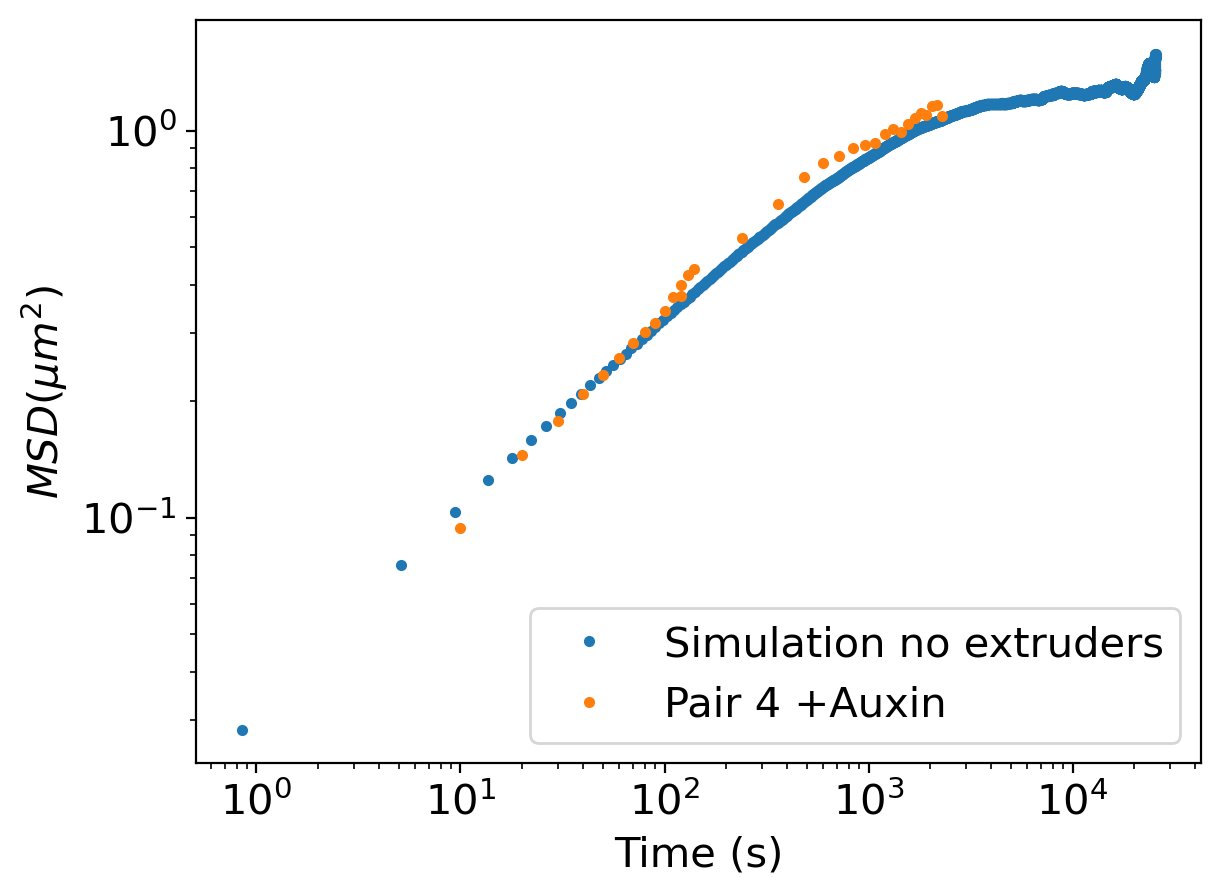

In [41]:
time_exp = np.load('./pair4_plus_auxin_time.npy')
msd_exp = np.load('./pair4_plus_auxin_msd.npy')

experimental_dist_plusAID  = 0.74
lscale = dist.mean()/experimental_dist_plusAID # conversion factor from simulation length to microns

dt = 6.801130716528638 # simulation dt in simulation units
tscale = 800 # conversion factor from simulation time step to seconds, modify to align sim to experimental msd

simulation_time = np.arange(len(msd)) * dt / tscale

w1,w2 = 100, -1
m = 500
x = simulation_time[w1:w2:m]
y = msd[w1:w2:m]/lscale**2
plt.ylabel(r'$MSD (\mu m^2)$')
plt.xlabel(r'Time (s)')
plt.tight_layout()
plt.loglog(x, y, '.', label = 'Simulation no extruders')
plt.loglog(time_exp, msd_exp, '.', label = 'Pair 4 +Auxin')
plt.legend()

print('conversion factors:')
print(f'Divide simulation by {lscale} to get microns')
print(f'Divide simulation time by {dt/tscale} to get seconds')

In [ ]:
# fit interaction radius
# compute search time for different interaction radii (target size), using 3D trajectories, to compare to experimental FPTs

traj_poly = reshape_to_polymers(traj3D, M=M) # use 3D traj for FPT calculation
rij = extract_rij(traj_poly, k=k, shift=1)   # (T, Npairs, 3)

target_sizes = np.round(np.linspace(1, 6, 20), 3) / lscale  # in microns
fpts_results = []
for target_size in target_sizes:
    print(f"\nTarget size: {round(target_size * 1000, 1)} nm")
    all_fpts = []
    dists = np.linalg.norm(rij, axis=2) / lscale  # shape (T, Npairs), in microns
    for i in range(dists.shape[1]):
        signal = dists[:, i]   # in microns
        fpts = compute_fpts(signal, target_size=target_size, Nsamples=5000, t_min=0)
        all_fpts.append(fpts)
    all_fpts = np.concatenate(all_fpts)
    mean_fpt = all_fpts.mean() * dt / tscale / 60  # in minutes
    fpts_results.append(mean_fpt)
    print(f"Mean FPT: {mean_fpt :.3f} minutes")

Reshaped trajectory to (M=10, T=3000000, Nprobe=10, 3).
Extracted rij with shape (3000000, 80, 3) (T, Npairs, 3).

Target size: 30.4 nm
Mean FPT: 114.549 minutes

Target size: 38.4 nm
Mean FPT: 67.909 minutes

Target size: 46.4 nm
Mean FPT: 45.180 minutes

Target size: 54.4 nm
Mean FPT: 37.497 minutes

Target size: 62.4 nm
Mean FPT: 31.054 minutes

Target size: 70.4 nm
Mean FPT: 27.624 minutes

Target size: 78.4 nm
Mean FPT: 24.867 minutes

Target size: 86.4 nm
Mean FPT: 22.994 minutes

Target size: 94.4 nm
Mean FPT: 21.328 minutes

Target size: 102.4 nm
Mean FPT: 20.298 minutes

Target size: 110.4 nm
Mean FPT: 18.841 minutes

Target size: 118.4 nm
Mean FPT: 17.540 minutes

Target size: 126.4 nm
Mean FPT: 16.702 minutes

Target size: 134.4 nm
Mean FPT: 16.042 minutes

Target size: 142.4 nm
Mean FPT: 15.021 minutes

Target size: 150.4 nm
Mean FPT: 13.936 minutes

Target size: 158.4 nm
Mean FPT: 13.379 minutes

Target size: 166.4 nm
Mean FPT: 12.770 minutes

Target size: 174.4 nm
Mean FP

target_size = 75-82 nm gives FPT = 25.5 +/- 1.2 min
=> reaction radius = 75-82 nm
in simulation units = 2.467578893143138 - 2.6978862565031645


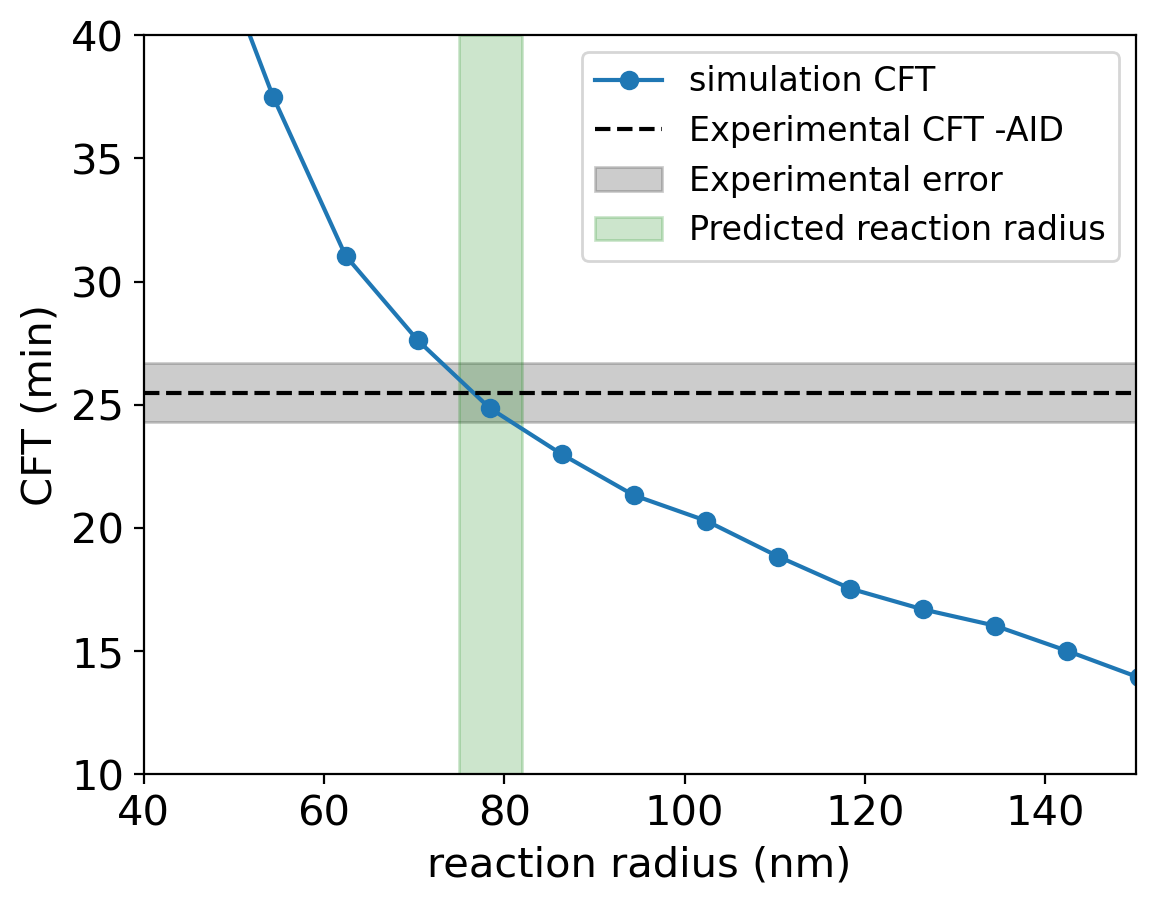

In [47]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20


experimental_fpt_plusAID = 25.5
error_fpt_plusAID = 1.2
experimental_fpt_minusAID = 17.8
error_fpt_minusAID = 0.8

y = fpts_results
x = target_sizes * 1000  # in nm


# plt.axvline(30)
plt.plot(x, y, '-o', label = 'simulation CFT')
plt.xlabel('reaction radius (nm)')
plt.ylabel('CFT (min)')

plt.axhline(experimental_fpt_plusAID, color = 'black', linestyle = '--', label = 'Experimental CFT -AID')
plt.fill_between([-5, 150], experimental_fpt_plusAID - error_fpt_plusAID, experimental_fpt_plusAID + error_fpt_plusAID, color='black', alpha=0.2, label = 'Experimental error')
plt.fill_betweenx([10, 40], 75, 82, color='green', alpha=0.2, label = 'Predicted reaction radius')

plt.legend(fontsize = 12)
plt.ylim(10, 40)
plt.xlim(40, 150)

print('target_size = 75-82 nm gives FPT = 25.5 +/- 1.2 min')
print('=> reaction radius = 75-82 nm')
print('in simulation units =', (75/1000)*lscale, '-', (82/1000)*lscale)

In [44]:
experimental_fpt_plusAID  = 25.5  # minutes, no extrusion
error_fpt_plusAID         = 1.2
experimental_fpt_minusAID = 17.8  # minutes, with extrusion
error_fpt_minusAID        = 0.8

folders = {
    'no_extrusion_precomputed': 'No extrusion',
    'processivity_210_d_2100_precomputed': 'Extrusion',
}

M = 10
k = 2
shift = 1
target_size = 2.6
Nsamples_fpt = 5000
t_min = 1

sim_fpt_minutes = {}
sim_mean_distances = {}    

for folder, label in folders.items():
    print(f"\nAnalyzing folder: {folder} ({label})")

    # Load trajectory
    traj3D = load_data_parallel(folder, prefix="trajprob")

    # convert to 2D trajectories for distance calculations
    traj2D = np.zeros(traj3D.shape)
    traj2D[:,:,0] = traj3D[:,:,0]
    traj2D[:,:,1] = traj3D[:,:,1]
    traj_poly_2D = reshape_to_polymers(traj2D, M=M)

    # Extract rij
    rij_2D = extract_rij(traj_poly_2D, k=k, shift=shift)   # shape (T, Npairs, 3)
    dists_2D = np.linalg.norm(rij_2D, axis=-1)             # shape (T, Npairs)

    mean_dist = dists_2D.mean()
    sim_mean_distances[label] = mean_dist/lscale
    print(f"Mean distance ({label}): {mean_dist:.3f} (simulation units)")

    # Make 3D trajectories for FPT calculations
    traj_poly_3D = reshape_to_polymers(traj3D, M=M)
    rij_3D = extract_rij(traj_poly_3D, k=k, shift=shift)
    dists_3D = np.linalg.norm(rij_3D, axis=-1)             # shape (T, Npairs)

    # --- Compute FPTs ------------------------------------------
    all_fpts = []
    for pair_idx in range(dists_3D.shape[1]):
        signal = dists_3D[:, pair_idx]
        fpts = compute_fpts(signal,
                            target_size=target_size,
                            Nsamples=Nsamples_fpt,
                            t_min=t_min)
        if fpts.size > 0:
            all_fpts.append(fpts)

    if not all_fpts:
        raise RuntimeError(f"No FPTs found for folder {folder}")

    all_fpts = np.concatenate(all_fpts)

    # Convert to minutes
    mean_fpt_min = all_fpts.mean() * dt / tscale / 60.0
    sim_fpt_minutes[label] = mean_fpt_min
    print(f"Mean FPT ({label}): {mean_fpt_min:.3f} minutes")


Analyzing folder: no_extrusion_precomputed (No extrusion)
#frames = 1500
None


Reshaped trajectory to (M=10, T=3000000, Nprobe=10, 3).
Extracted rij with shape (3000000, 80, 3) (T, Npairs, 3).
Mean distance (No extrusion): 24.347 (simulation units)
Reshaped trajectory to (M=10, T=3000000, Nprobe=10, 3).
Extracted rij with shape (3000000, 80, 3) (T, Npairs, 3).
Mean FPT (No extrusion): 24.813 minutes

Analyzing folder: processivity_210_d_2100_precomputed (Extrusion)
#frames = 500
None
Reshaped trajectory to (M=10, T=10000000, Nprobe=10, 3).
Extracted rij with shape (10000000, 80, 3) (T, Npairs, 3).
Mean distance (Extrusion): 22.741 (simulation units)
Reshaped trajectory to (M=10, T=10000000, Nprobe=10, 3).
Extracted rij with shape (10000000, 80, 3) (T, Npairs, 3).
Mean FPT (Extrusion): 18.662 minutes


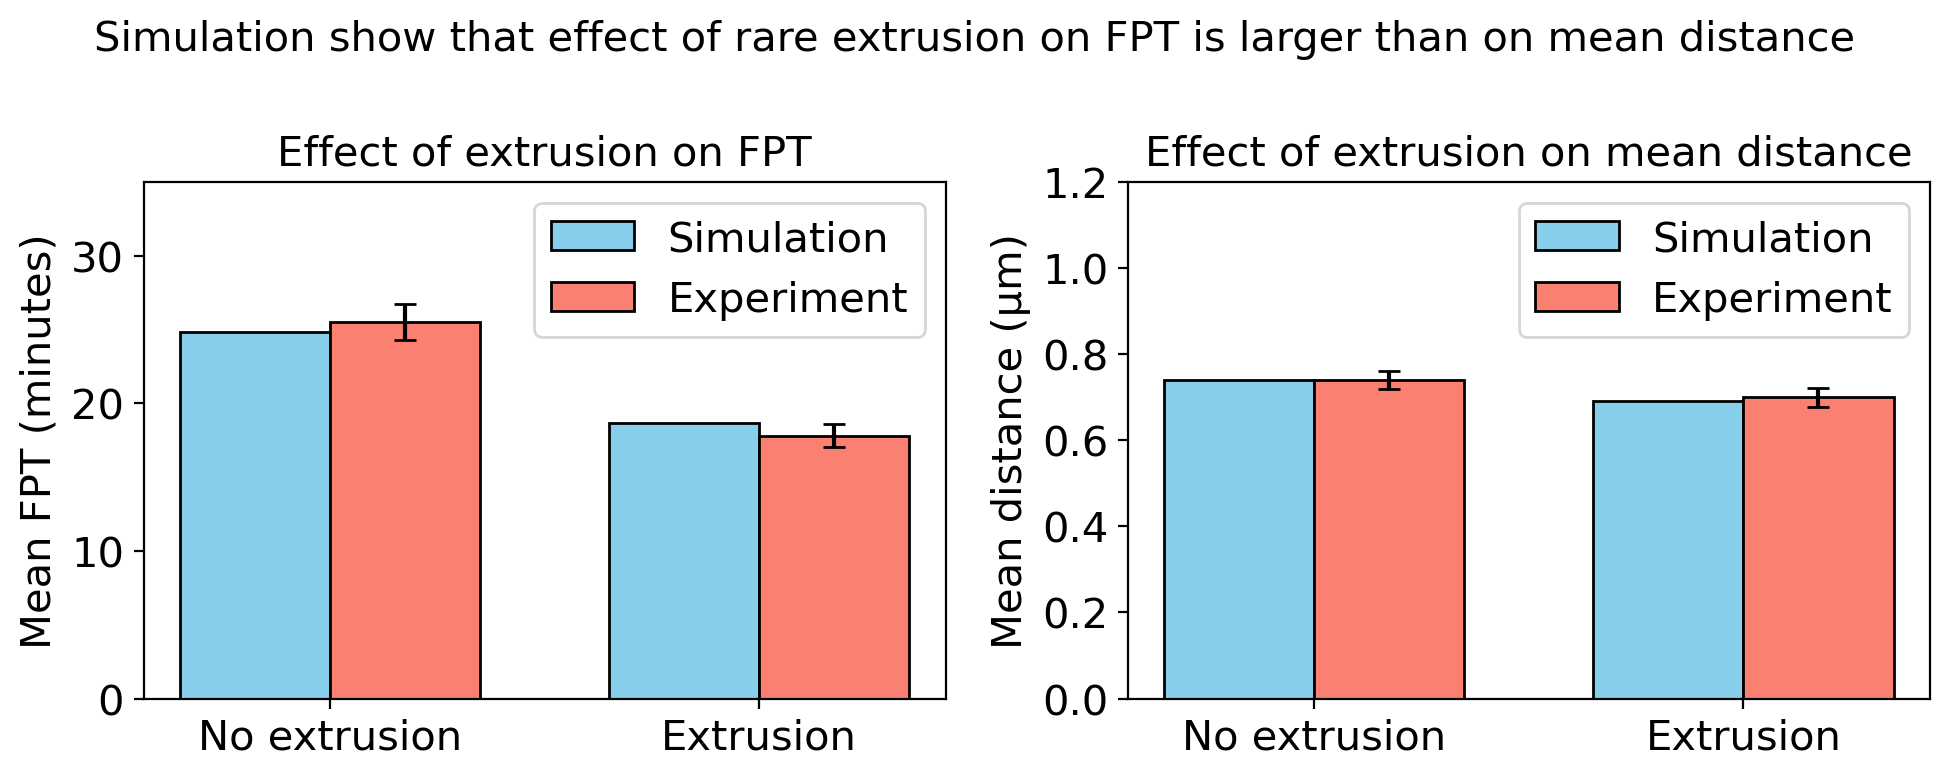

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# --- Experimental values (plusAID = no extrusion, minusAID = with extrusion) ---
experimental_fpt_plusAID  = 25.5  # minutes, no extrusion
error_fpt_plusAID         = 1.2
experimental_fpt_minusAID = 17.8  # minutes, with extrusion
error_fpt_minusAID        = 0.8

# Experimental distances (µm)
experimental_dist_plusAID  = 0.74   # no extrusion
error_dist_plusAID         = 0.021
experimental_dist_minusAID = 0.70   # with extrusion
error_dist_minusAID        = 0.022

# --- Organize data for plotting -----------------------------------------------
conditions = ['No extrusion', 'Extrusion']

# FPT: simulation and experiment
sim_vals = [
    sim_fpt_minutes['No extrusion'],
    sim_fpt_minutes['Extrusion'],
]

exp_vals = [
    experimental_fpt_plusAID,   # no extrusion
    experimental_fpt_minusAID,  # with extrusion
]

exp_errs = [
    error_fpt_plusAID,
    error_fpt_minusAID,
]

# Distances: simulation and experiment
sim_dist_vals = [
    sim_mean_distances['No extrusion'],
    sim_mean_distances['Extrusion'],
]

exp_dist_vals = [
    experimental_dist_plusAID,    # no extrusion
    experimental_dist_minusAID,   # with extrusion
]

exp_dist_errs = [
    error_dist_plusAID,
    error_dist_minusAID,
]

# --- Bar plots: FPT (left) and distance (right) -------------------------------
x = np.arange(len(conditions))
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Left: FPT ----------------------------------------------------------------
ax1.bar(x - bar_width/2, sim_vals, width=bar_width,
        label='Simulation', color='skyblue', edgecolor='black')
ax1.bar(x + bar_width/2, exp_vals, width=bar_width,
        yerr=exp_errs, capsize=4,
        label='Experiment', color='salmon', edgecolor='black')

ax1.set_xticks(x)
ax1.set_xticklabels(conditions)
ax1.set_ylabel("Mean FPT (minutes)")
ax1.set_title("Effect of extrusion on FPT")
ax1.set_ylim(0, 35)
ax1.legend()

# --- Right: distance ----------------------------------------------------------
ax2.bar(x - bar_width/2, sim_dist_vals, width=bar_width,
        label='Simulation', color='skyblue', edgecolor='black')
ax2.bar(x + bar_width/2, exp_dist_vals, width=bar_width,
        yerr=exp_dist_errs, capsize=4,
        label='Experiment', color='salmon', edgecolor='black')

ax2.set_xticks(x)
ax2.set_xticklabels(conditions)
ax2.set_ylabel("Mean distance (µm)")
ax2.set_title("Effect of extrusion on mean distance")
# You can tune this if you want tighter bounds:
ax2.set_ylim(0, 1.2)
ax2.legend()

fig.suptitle("Simulation show that effect of rare extrusion on FPT is larger than on mean distance")

plt.tight_layout()
plt.show()